## Fossil classification with RevNet

In this notebook we will do fossil classification using the Fossilnet dataset which can be downloaded at https://github.com/softwareunderground/fossilnet/blob/master/dataloaders/pytorch.py. The dataset consists of 3000 fossils from 10 different classes. We will use both the standard ResNet architecture and the RevNet architecture. Both ResNet and RevNet are constrcuted using the MeMCNN library, that can be found at https://github.com/silvandeleemput/memcnn. MeMCNN is a library that users and invertible wrapper module that makes sure that the weights needed for backpropagation are not stored for invertible modules. 

In [1]:
import torch 
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from dataloader_fossilnet import FossilNET
from memcnn.models.resnet import ResNet, BasicBlock, Bottleneck, RevBasicBlock, RevBottleneck
# from train import train, evaluate, classification
import torchvision
from torchvision import transforms
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import warnings
import logging
from torchsummary import summary
warnings.filterwarnings('ignore')

In [2]:
# from utils import set_seed
torch.cuda.empty_cache()

device = 'cuda:0'
print(torch.cuda.get_device_name(device))

NVIDIA GeForce RTX 3090


In [3]:
def train(network, criterion, optimizer, data_loader, device='cpu'):
    """Training epoch
    
    Run a single epoch of network training
    
    Parameters
    ----------
    network : :obj:`torch.nn`
        Network
    criterion : :obj:`torch.nn`
        Loss
    optimizer : :obj:`torch.optim`, optional
        Optimizer
    data_loader : :obj:`torch.utils.data.DataLoader`
        Dataloader
    device : :obj:`str`
        Device
    Returns
    -------
    loss : :obj:`float`
        Epoch total loss
    """
    network.train()
    loss = 0
    for data, target in data_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        prediction = network(data)
        target = F.one_hot(target, 10)
        ls = criterion(prediction, target.type(torch.float16))
        ls.backward()
        optimizer.step()
        loss += ls.item()
    return loss

In [4]:
def train_network(network, epochs, train_loader, device='cpu', lr=1e-2, momentum=0.9):
    """Network training

    Train blind-spot network seismic shot gather in continuous mode based on pre-defined sequence of firing times.

    Parameters
    ----------
    network : :obj:`torch.nn`
        Network
    epochs : :obj:`int`
        Number of epochs
    train_loader : :obj:`torch.utils.data.DataLoader`
        Dataloader
    todenoise : :obj:`torch.Tensor`
        Data to denoise (during training for visualization purposes)
    device : :obj:`str`
        Device

    Returns
    -------
    network : :obj:`torch.nn`
        Updated network

    """
    criterion = nn.CrossEntropyLoss()
#     optimizer = optim.Adam(network.parameters(), lr=lr)
    optimizer = torch.optim.SGD(network.parameters(), lr=lr)

    for i in range(epochs):
        train_loss = train(network, criterion, optimizer, train_loader, device=device)
        if i%10 == 0:
            print(f'Training loss at epoch {i}: {train_loss:.2f}')

    return network

In [5]:
def test(network, criterion, test_loader):
    """Network testing
    
    Test the network
    
    Parameters
    ----------
    network : :obj:`torch.nn`
        Network
    epochs : :obj:`int`
        Number of epochs
    test_loader : :obj:`torch.utils.data.DataLoader`
        Dataloader containing the test data
    todenoise : :obj:`torch.Tensor`
        Data to denoise (during training for visualization purposes)
    device : :obj:`str`
        Device

    Returns
    -------
    test_loss : :obj:`np.float`
        test loss
    """
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data)
            test_loss += criterion(output, target).item()
            prediction = output.data.max(1, keepdim=True)[1]
            correct += prediction.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    
    return test_loss

First we load the Fossilnet dataset. Make sure you download it first before running this cell!

In [6]:
# From https://pytorch.org/hub/pytorch_vision_resnet/
imagenet_normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                          std=[0.229, 0.224, 0.225])

transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        imagenet_normalize
])

# Get the training, validation and test data
training_data = FossilNET('dataset', 'train', transform=transform)
validation_data = FossilNET('dataset', 'val', transform=transform)
test_data = FossilNET('dataset', 'test', transform=transform)

# Put the training data into a train loader
train_loader = DataLoader(dataset=training_data, batch_size=64, shuffle=True)
test_loader  = DataLoader(dataset=test_data, batch_size=1028, shuffle=True)

Let's look at a few fossils

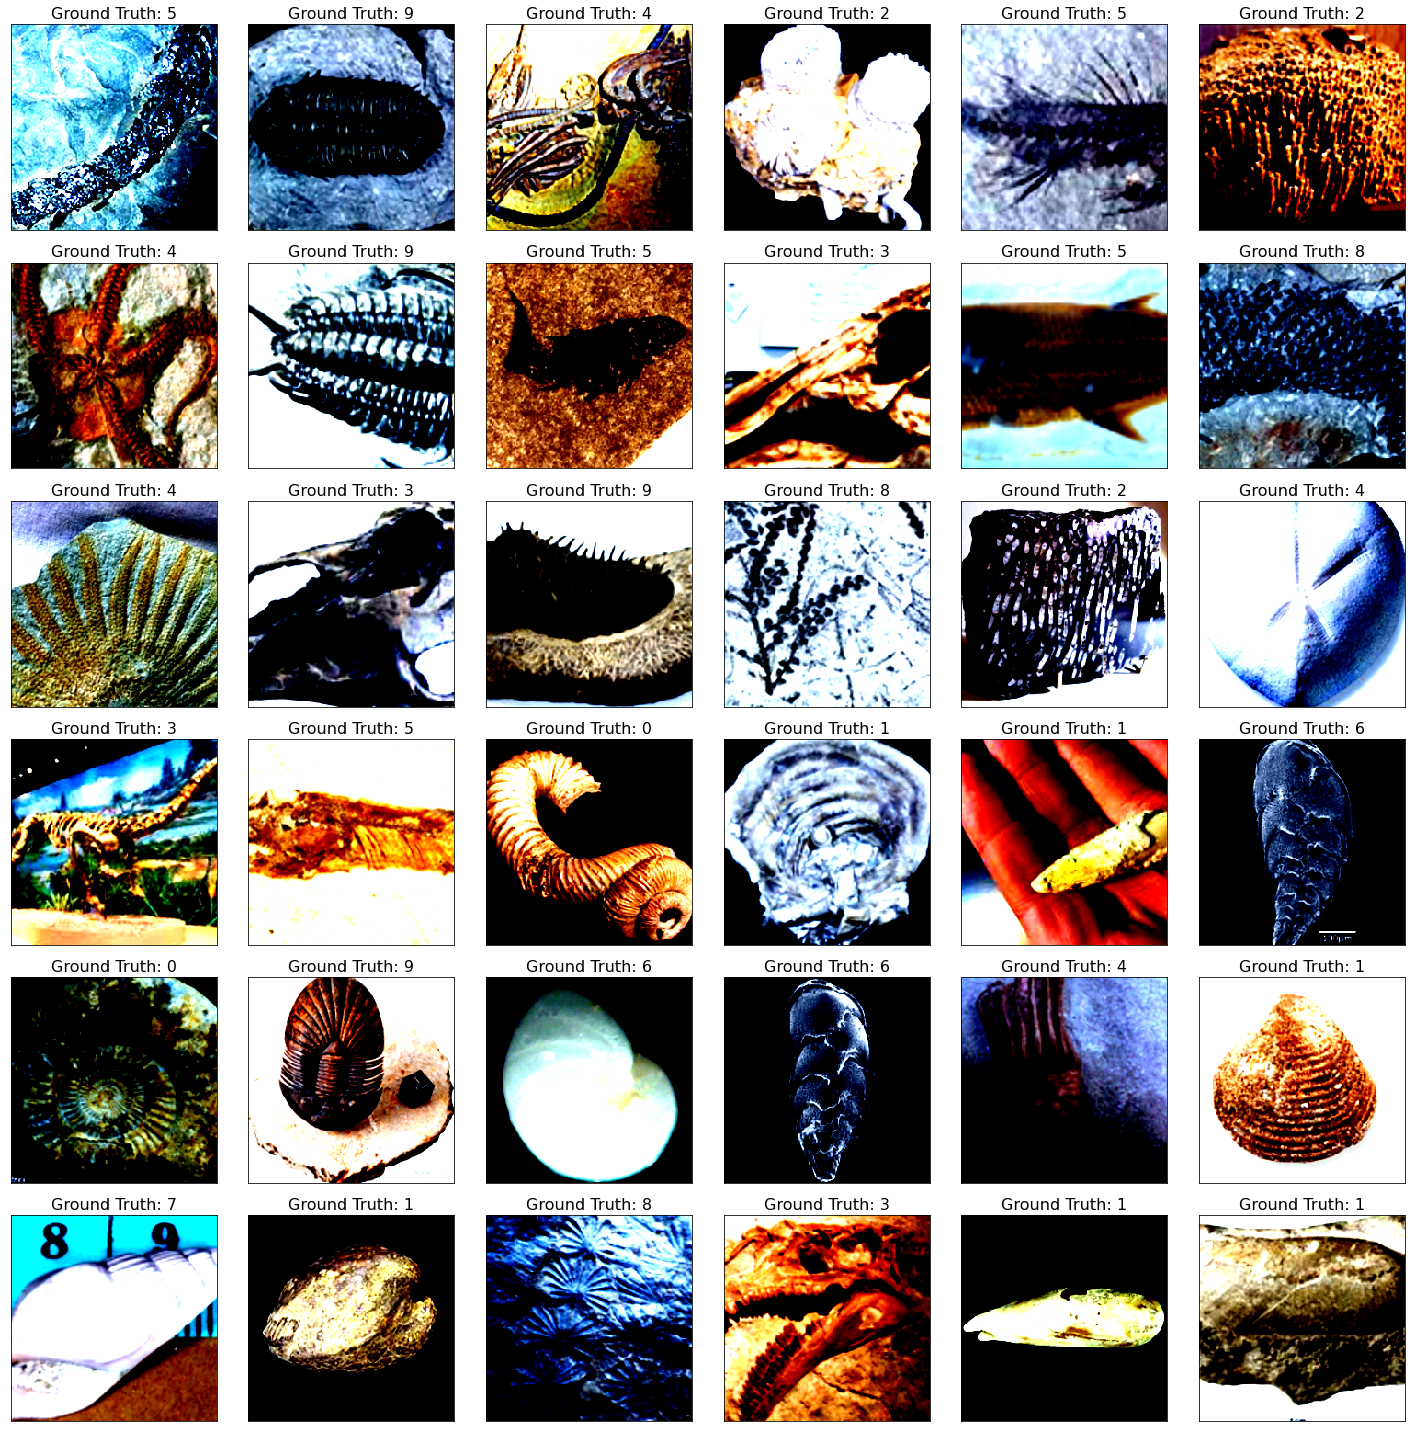

In [7]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

# There is some annoying warning regarding clipping because of the scaling of the data and this ignores is
logger = logging.getLogger()
old_level = logger.level
logger.setLevel(100)

fig = plt.figure(figsize=(20,20))
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.tight_layout()
    plt.imshow((example_data[i].permute(1, 2, 0)), interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]), fontsize=16)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout();

logger.setLevel(old_level)

Now we are ready to build the ResNet and RevNet to do the classification. Below are the most popular ResNet architectures that we can use for the classification. We start with the biggest one: ResNet 152.

In [8]:
# Make the ResNet
layers = [3, 8, 36, 3]
ResNet152 = ResNet(Bottleneck, layers, num_classes=10)
ResNet152.to(device)

# Make the RevNet
RevNet152 = ResNet(RevBottleneck, layers, num_classes=10)
RevNet152.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
  (relu): ReLU()
  (layer1): Sequential(
    (0): Bottleneck(
      (bottleneck_sub): BottleneckSub(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn3): BatchNorm2d(64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (relu): ReLU(inplace=True)
      )
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(256, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      )
    )
    (1)

And now we can train both networks

In [ ]:
epochs = 1000
train_network(ResNet152, epochs, train_loader, device=device)

In [ ]:
epochs = 1000
train_network(RevNet152, epochs, train_loader, device=device)

In [ ]:
layers = [2, 2, 2, 2]
ResNet18 = ResNet(BasicBlock, layers, num_classes=10)
ResNet18.to(device)

RevNet18 = ResNet(RevBasicBlock, layers, num_classes=10)
RevNet18.to(device)

In [ ]:
layers = [3, 4, 23, 3]
ResNet101 = ResNet(Bottleneck, layers, num_classes=10)
ResNet101.to(device)

RevNet101 = ResNet(RevBottleneck, layers, num_classes=10)
RevNet101.to(device)

In [ ]:
summary(ResNet152, (3, 512, 512))

In [ ]:
summary(RevNet152, (3, 512, 512))

Now let's look at how MeMCNN deals with storage of the forward operator for invertible networks. Do not run the code below! It's just to look at

In [ ]:
class BasicBlockSub(nn.Module):
    def __init__(self, inplanes, planes, stride=1, noactivation=False):
        super(BasicBlockSub, self).__init__()
        self.noactivation = noactivation
        if not self.noactivation:
            self.bn1 = batch_norm(inplanes)
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn2 = batch_norm(planes)
        self.conv2 = conv3x3(planes, planes)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        if not self.noactivation:
            x = self.bn1(x)
            x = self.relu(x)
        x = self.conv1(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv2(x)
        return 

In [ ]:
class RevBasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, noactivation=False):
        super(RevBasicBlock, self).__init__()
        if downsample is None and stride == 1:
            gm = BasicBlockSub(inplanes // 2, planes // 2, stride, noactivation)
            fm = BasicBlockSub(inplanes // 2, planes // 2, stride, noactivation)
            coupling = create_coupling(Fm=fm, Gm=gm, coupling='additive')
            self.revblock = InvertibleModuleWrapper(fn=coupling, keep_input=False)
        else:
            self.basicblock_sub = BasicBlockSub(inplanes, planes, stride, noactivation)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        if self.downsample is not None:
            out = self.basicblock_sub(x)
            residual = self.downsample(x)
            out += residual
        else:
            out = self.revblock(x)
        return 

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, noactivation=False):
        super(BasicBlock, self).__init__()
        self.basicblock_sub = BasicBlockSub(inplanes, planes, stride, noactivation)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x
        out = self.basicblock_sub(x)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        return out

In [ ]:
class InvertibleModuleWrapper(nn.Module):
    def __init__(self, fn, keep_input=False, keep_input_inverse=False, num_bwd_passes=1,
                 disable=False, preserve_rng_state=False):
        """
        The InvertibleModuleWrapper which enables memory savings during training by exploiting
        the invertible properties of the wrapped module.
        Parameters
        ----------
            fn : :obj:`torch.nn.Module`
                A torch.nn.Module which has a forward and an inverse function implemented with
                :math:`x == m.inverse(m.forward(x))`
            keep_input : :obj:`bool`, optional
                Set to retain the input information on forward, by default it can be discarded since it will be
                reconstructed upon the backward pass.
            keep_input_inverse : :obj:`bool`, optional
                Set to retain the input information on inverse, by default it can be discarded since it will be
                reconstructed upon the backward pass.
            num_bwd_passes :obj:`int`, optional
                Number of backward passes to retain a link with the output. After the last backward pass the output
                is discarded and memory is freed.
                Warning: if this value is raised higher than the number of required passes memory will not be freed
                correctly anymore and the training process can quickly run out of memory.
                Hence, The typical use case is to keep this at 1, until it raises an error for raising this value.
            disable : :obj:`bool`, optional
                This will disable using the InvertibleCheckpointFunction altogether.
                Essentially this renders the function as :math:`y = fn(x)` without any of the memory savings.
                Setting this to true will also ignore the keep_input and keep_input_inverse properties.
            preserve_rng_state : :obj:`bool`, optional
                Setting this will ensure that the same RNG state is used during reconstruction of the inputs.
                I.e. if keep_input = False on forward or keep_input_inverse = False on inverse. By default
                this is False since most invertible modules should have a valid inverse and hence are
                deterministic.
        Attributes
        ----------
            keep_input : :obj:`bool`, optional
                Set to retain the input information on forward, by default it can be discarded since it will be
                reconstructed upon the backward pass.
            keep_input_inverse : :obj:`bool`, optional
                Set to retain the input information on inverse, by default it can be discarded since it will be
                reconstructed upon the backward pass.
        Note
        ----
            The InvertibleModuleWrapper can be used with mixed-precision training using
            :obj:`torch.cuda.amp.autocast` as of torch v1.6 and above. However, inputs will always be cast
            to :obj:`torch.float32` internally. This is done to minimize autocasting inputs to a different datatype
            which usually results in a disconnected computation graph and will raise an error on the backward pass.
        """
        super(InvertibleModuleWrapper, self).__init__()
        self.disable = disable
        self.keep_input = keep_input
        self.keep_input_inverse = keep_input_inverse
        self.num_bwd_passes = num_bwd_passes
        self.preserve_rng_state = preserve_rng_state
        self._fn = fn

    def forward(self, *xin):
        """Forward operation :math:`R(x) = y`
        Parameters
        ----------
            *xin : :obj:`torch.Tensor` tuple
                Input torch tensor(s).
        Returns
        -------
            :obj:`torch.Tensor` tuple
                Output torch tensor(s) *y.
        """
        if not self.disable:
            y = InvertibleCheckpointFunction.apply(
                self._fn.forward,
                self._fn.inverse,
                self.keep_input,
                self.num_bwd_passes,
                self.preserve_rng_state,
                len(xin),
                *(xin + tuple([p for p in self._fn.parameters() if p.requires_grad])))
        else:
            y = self._fn(*xin)

        # If the layer only has one input, we unpack the tuple again
        if isinstance(y, tuple) and len(y) == 1:
            return y[0]
        return y

    def inverse(self, *yin):
        """Inverse operation :math:`R^{-1}(y) = x`
        Parameters
        ----------
            *yin : :obj:`torch.Tensor` tuple
                Input torch tensor(s).
        Returns
        -------
            :obj:`torch.Tensor` tuple
                Output torch tensor(s) *x.
        """
        if not self.disable:
            x = InvertibleCheckpointFunction.apply(
                self._fn.inverse,
                self._fn.forward,
                self.keep_input_inverse,
                self.num_bwd_passes,
                self.preserve_rng_state,
                len(yin),
                *(yin + tuple([p for p in self._fn.parameters() if p.requires_grad])))
        else:
            x = self._fn.inverse(*yin)

        # If the layer only has one input, we unpack the tuple again
        if isinstance(x, tuple) and len(x) == 1:
            return x[0]
        return 

In [ ]:
class InvertibleCheckpointFunction(torch.autograd.Function):
    @staticmethod
    @custom_fwd(cast_inputs=torch.float32)
    def forward(ctx, fn, fn_inverse, keep_input, num_bwd_passes, preserve_rng_state, num_inputs, *inputs_and_weights):
        # store in context
        ctx.fn = fn
        ctx.fn_inverse = fn_inverse
        ctx.keep_input = keep_input
        ctx.weights = inputs_and_weights[num_inputs:]
        ctx.num_bwd_passes = num_bwd_passes
        ctx.preserve_rng_state = preserve_rng_state
        ctx.num_inputs = num_inputs
        inputs = inputs_and_weights[:num_inputs]

        if preserve_rng_state:
            ctx.fwd_cpu_state = torch.get_rng_state()
            # Don't eagerly initialize the cuda context by accident.
            # (If the user intends that the context is initialized later, within their
            # run_function, we SHOULD actually stash the cuda state here.  Unfortunately,
            # we have no way to anticipate this will happen before we run the function.)
            ctx.had_cuda_in_fwd = False
            if torch.cuda._initialized:
                ctx.had_cuda_in_fwd = True
                ctx.fwd_gpu_devices, ctx.fwd_gpu_states = get_device_states(*inputs)

        ctx.input_requires_grad = [element.requires_grad for element in inputs]

        with torch.no_grad():
            # Makes a detached copy which shares the storage
            x = [element.detach() for element in inputs]
            outputs = ctx.fn(*x)

        if not isinstance(outputs, tuple):
            outputs = (outputs,)

        # Detaches y in-place (inbetween computations can now be discarded)
        detached_outputs = tuple([element.detach_() for element in outputs])

        # clear memory from inputs
        if not ctx.keep_input:
            # PyTorch 1.0+ way to clear storage
            for element in inputs:
                element.storage().resize_(0)

        # store these tensor nodes for backward pass
        ctx.inputs = [inputs] * num_bwd_passes
        ctx.outputs = [detached_outputs] * num_bwd_passes

        return detached_outputs

    @staticmethod
    @custom_bwd
    def backward(ctx, *grad_outputs):  # pragma: no cover
        if not torch.autograd._is_checkpoint_valid():
            raise RuntimeError("InvertibleCheckpointFunction is not compatible with .grad(), please use .backward() if possible")
        # retrieve input and output tensor nodes
        if len(ctx.outputs) == 0:
            raise RuntimeError("Trying to perform backward on the InvertibleCheckpointFunction for more than "
                               "{} times! Try raising `num_bwd_passes` by one.".format(ctx.num_bwd_passes))
        inputs = ctx.inputs.pop()
        outputs = ctx.outputs.pop()

        # recompute input if necessary
        if not ctx.keep_input:
            # Stash the surrounding rng state, and mimic the state that was
            # present at this time during forward.  Restore the surrounding state
            # when we're done.
            rng_devices = []
            if ctx.preserve_rng_state and ctx.had_cuda_in_fwd:
                rng_devices = ctx.fwd_gpu_devices
            with torch.random.fork_rng(devices=rng_devices, enabled=ctx.preserve_rng_state):
                if ctx.preserve_rng_state:
                    torch.set_rng_state(ctx.fwd_cpu_state)
                    if ctx.had_cuda_in_fwd:
                        set_device_states(ctx.fwd_gpu_devices, ctx.fwd_gpu_states)
                # recompute input
                with torch.no_grad():
                    inputs_inverted = ctx.fn_inverse(*outputs)
                    if not isinstance(inputs_inverted, tuple):
                        inputs_inverted = (inputs_inverted,)
                    for element_original, element_inverted in zip(inputs, inputs_inverted):
                        element_original.storage().resize_(int(np.prod(element_original.size())))
                        element_original.set_(element_inverted)

        # compute gradients
        with torch.set_grad_enabled(True):
            detached_inputs = tuple([element.detach().requires_grad_() for element in inputs])
            temp_output = ctx.fn(*detached_inputs)
        if not isinstance(temp_output, tuple):
            temp_output = (temp_output,)

        gradients = torch.autograd.grad(outputs=temp_output, inputs=detached_inputs + ctx.weights, grad_outputs=grad_outputs)

        # Setting the gradients manually on the inputs and outputs (mimic backwards)
        for element, element_grad in zip(inputs, gradients[:ctx.num_inputs]):
            element.grad = element_grad

        for element, element_grad in zip(outputs, grad_outputs):
            element.grad = element_grad

        return (None, None, None, None, None, None) + gradients